In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Class 11: Introduction to the `linearsolve` Module

In general, dynamic stochastic general equilibrium (DSGE) models do not admit analytic (i.e., pencil-and-paper) solutions and they are time-consuming to work with. The `linearsolve` module approximates, solves, and simulates DSGE models and therefore makes DSGE models easier to use.

## Installing `linearsolve`

`linearsolve` is not included in the Anaconda Python installation and so before you can import it, you need to download and install the `linearsolve` package from PyPI, the Python Package Index. To install, run the following command in a Jupyter Notebook cell:

    pip install linearsolve --upgrade
    
Alternatively, you can install from the command line. In Windows, open the Anaconda Prompt and in Mac, open the Terminal and run the following commmand. You only have to install the package once.

## More information about `linearsolve`

Documentation, including examples, for `linearsolve` is availabe here:

https://www.briancjenkins.com/linearsolve/docs/build/html/index.html

You can view the code in this GitHub repository: https://github.com/letsgoexploring/linearsolve

In [2]:
# Import the linearsolve under the `ls` namespace
import linearsolve as ls

## Example: A One-Equation Model of TFP

Consider the following AR(1) specification for $\log$ TFP:

\begin{align}
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1},
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. The goal is to simulate $A_t$ around its steady state value of $A = 1$. Let's compute the model simulation with `linearsolve`. To do this we need to do several things:

1. Create a Pandas series that stores the names of the parameters of the model.
2. Define a function that returns the equilibrium conditions of the model solved for zero.
3. Initialize an instance of the `linearsolve.model` class
4. Compute and input the steady state of the model.
5. Approximate and solve the model.
6. Compute simulations of the model.

Use the following values for the simulation:

| $$\rho$$ | $$\sigma$$ |
|----------|------------|
| 0.95     | 0.01       |

**Step 1:** Create a variable called `parameters` that stores parameter values as a Pandas Series.

In [3]:
# Create a variable called `parameters` that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['rho'] = .95

# Display stored parameter values
display(parameters)

rho    0.95
dtype: float64

In [4]:
# Create a variable called `sigma` that stores the value of sigma
sigma = 0.01

In [5]:
# Create variable called `exo_states` that stores the names of each exogenous state variable.
exo_states = ['a']

**Step 2:** Define a function called `equations` that evaluates the equilibrium 
equations of model solved for zero and omitting any exogenous shocks. The function should accept three arguments:

1. `variables_forward`: Values of $t+1$-dated variables
2. `variables_current`: Values of $t$-dated variables
3. `parameters`: Pandas Series with the parameters for the model

The function should return a NumPy array of the model's equilibrium conditions solved for zero.

In [6]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equations(variables_forward,variables_current,parameters):
    
    # Create a variable called 'p' that storres the model's parameters. PROVIDED.
    p = parameters
    
    # Create variable called 'cur' that stores the values of current (date t) variables. PROVIDED.
    cur = variables_current
    
    # Create variable called 'fwd' that stores the values of one-period-ahead (date t+1) variables. PROVIDED.
    fwd = variables_forward

    # Create variable called 'tfp_proc' that returns the law of motion for TFP solved for zero (exogenous shock excluded)
    tfp_proc = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Return equilibrium conditions stacked in a numpy array. PROVIDED.
    return np.array([
        tfp_proc
        ])

**Step 3:** Initialize a model instance using the `ls.model()` function. The 

1. `equations`: Name of function that stores the equilibrium conditions
4. `exo_state_names`: *exogenous* state variables (i.e., variables that are *predetermined* and subject to an exogenous shock)
4. `endo_state_names`: *endogenous* state variables (i.e., variables that are *predetermined* and *not* subject to an exogenous shock)
5. `costates`: variables that are not predetermined.
6. `parameters`: Pandas Series of parameter values

In this simple AR(1) model, there are no endoenous state variables and no costate variables.

In [7]:
# Initialize the model into a variable named `ar1_model` using the `ls.model()` function
ar1_model = ls.model(equations = equations,
                     exo_states=['a'],
                     parameters = parameters)

**Step 4:** Set the steady state of the model. Either use the `.compute_ss()` method which requires an initial guess of what the steady state is. Or set the steady state `.ss` attribute directly.

In [8]:
# Set an initial guess for the steady state solver
guess = pd.Series({
    'a':1
})

# Compute the steady state numerically using `.compute_ss()` method of `ar1_model`
ar1_model.compute_ss(guess)
display(ar1_model.ss)

a    1.0
dtype: float64

In [9]:
# Set the `.ss` attribute of `ar1_model` directly
ar1_model.ss = pd.Series({'a':1})

**Step 5:** Compute a transform the model into a linear approximation around the nonstochastic steady state. Then rewrite the equilibrium conditions so that all endogenous variables are expressed as linear functions of state variables and exogenous shocks.

In [10]:
# Appproximate and solve using the `.approximate_and_solve()` method of `ar1_model`
ar1_model.approximate_and_solve()

**Step 6:** Simulate the model using one of the following methods:

1. `.impulse()`: Compute impulse responses to a one-time shock to each exogenous variables. Results stored in `.irs` attribute.
2. `.stoch_sim()`: Compute stochastic simulation. Results stored in `.simulated` attribute.

By default all simulations are computed as the deviations from steady state: E.g., 

\begin{align}
\frac{A_t - \bar{A}}{\bar{A}}
\end{align}

where $\bar{A}$ is steady state $A_t$. If you do not want to divide by the steady state, set `normalize=False` in `.impulse()` and `.stoch_sim()`. To not not subtract the steady state in the numerator, set `center = False`.

First, we'll compute an impulse response simulation. Let's consider the effect of a one time shock to $\epsilon$ of 0.01 in period 5. Simulate 41 periods. By default, the shocks to each exogenous state variable are named `e_a+[VARIABLE NAME]`. So the name of the shock to TFP is `e_a`.

In [11]:
# Compute impulse response of a one-time shock to `e_a`
ar1_model.impulse(T=41,t0=5,shocks=[0.01])

The impulse response simulations are stored in the `.irs` attribute as a dictionary with keys equal to the names of the exogenous shocks. 

In [12]:
# Display `ar1_model.irs`
display(ar1_model.irs)

{'e_a':      e_a         a
 0   0.00  0.000000
 1   0.00  0.000000
 2   0.00  0.000000
 3   0.00  0.000000
 4   0.00  0.000000
 5   0.01  0.010000
 6   0.00  0.009500
 7   0.00  0.009025
 8   0.00  0.008574
 9   0.00  0.008145
 10  0.00  0.007738
 11  0.00  0.007351
 12  0.00  0.006983
 13  0.00  0.006634
 14  0.00  0.006302
 15  0.00  0.005987
 16  0.00  0.005688
 17  0.00  0.005404
 18  0.00  0.005133
 19  0.00  0.004877
 20  0.00  0.004633
 21  0.00  0.004401
 22  0.00  0.004181
 23  0.00  0.003972
 24  0.00  0.003774
 25  0.00  0.003585
 26  0.00  0.003406
 27  0.00  0.003235
 28  0.00  0.003074
 29  0.00  0.002920
 30  0.00  0.002774
 31  0.00  0.002635
 32  0.00  0.002503
 33  0.00  0.002378
 34  0.00  0.002259
 35  0.00  0.002146
 36  0.00  0.002039
 37  0.00  0.001937
 38  0.00  0.001840
 39  0.00  0.001748
 40  0.00  0.001661}

Let's look at the first 10 rows of the `'e_a'` element of `ar1_model.irs`.

In [13]:
# Display first 10 rows of the element in `ar1_model.irs` that corresponds to the shock to TFP
display(ar1_model.irs['e_a'].head(10))

,e_a,a
0,0.00,0.000000
1,0.00,0.000000
2,0.00,0.000000
3,0.00,0.000000
4,0.00,0.000000
5,0.01,0.010000
6,0.00,0.009500
7,0.00,0.009025
8,0.00,0.008574
9,0.00,0.008145


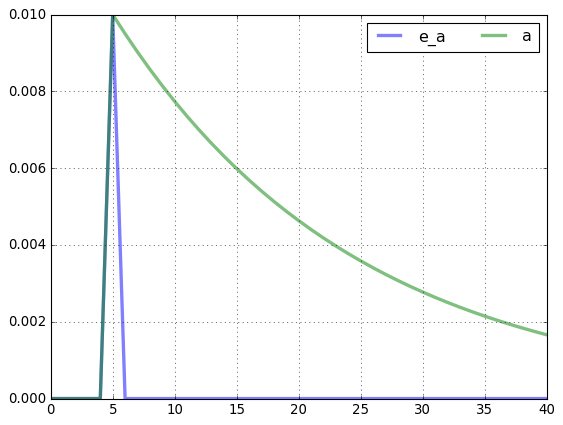

In [14]:
# Plot simulated impulse response to e_a
ar1_model.irs['e_a'][['e_a','a']].plot(lw=3,alpha=0.5,grid=True).legend(loc='upper right',ncol=2);

Next, we'll use the `.stoch_sim()` method to compute a stochastic simulation. The method takes arguments:

1. `seed`: Seed of NumPy RNG. (Optional)
2. `T`: Number of periods to simulate
3. `variances`: Variances of the exogenous shock process

The simulation should be for 201 periods.

In [15]:
# Compute stochastic simulation
ar1_model.stoch_sim(seed=126,T=201,variances= [sigma**2])

# Display the first 10 rows of `model.simulated`
display(ar1_model.simulated.head(10))

,e_a,a
0,0.009914,-0.033757
1,-0.007823,-0.039892
2,-0.010703,-0.048600
3,-0.011789,-0.057959
4,0.012503,-0.042558
5,-0.011411,-0.051841
6,0.008407,-0.040842
7,0.004843,-0.033957
8,-0.008628,-0.040887
9,0.000889,-0.037954


The stochastic simulations are stored in the `.stoch_sim` attribute as a Pandas `DataFrame`.

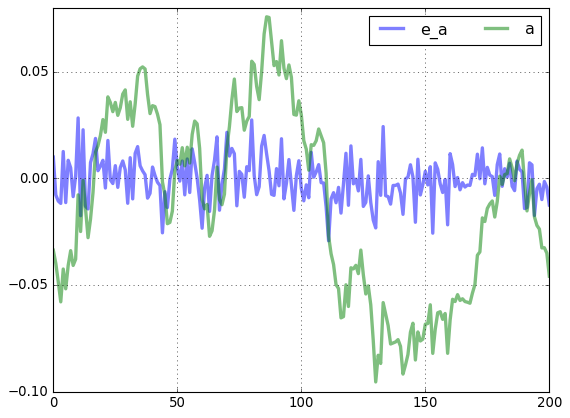

In [16]:
# Plot the stochastic simulation
ar1_model.simulated[['e_a','a']].plot(lw=3,alpha=0.5,grid=True).legend(loc='upper right',ncol=2);

## Example 2: The Stochastic Solow Growth Model Revisited

Now consider the following system of equations:

\begin{align}
Y_t & = A_t K_t^{\alpha} \\
K_{t+1} & = sY_t + (1-\delta) K_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. Let's simulate the model with `linearsolve`. Before proceding, let's also go ahead and rewrite the model with all variables moved to the right-hand side of the equations and dropping any exogenous shock processes:

\begin{align}
0 & = A_t K_t^{\alpha} - Y_t \\
0 & = sY_t + (1-\delta) K_t - K_{t+1}\\
0 & = \rho \log A_t - \log A_{t+1}
\end{align}

apital and TFP are called *state variables* because theit period $t+1$ values are determined by their period $t$ values. TFP is an *exogenous state variable* because it's $t+1$ value is subject to an exogenous shock $\epsilon_{t+1}$. Capital is an *endogenous state variable* because the $t+1$ value is completely determined in date $t$.  Output is called a *costate* or *control* variable. Note that the model as 3 endogenous variables with 2 state variables, and one exogenous state variable. 

Use the following values for the simulation:

| $$\rho$$ | $$\sigma$$ | $$s$$ | $$\alpha$$ | $$\delta $$ | $$T$$  |
|----------|------------|-------|------------|-------------|--------|
| 0.75     | 0.006      | 0.1   | 0.35       |  0.025      | 201    |

### Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [17]:
# Create a variable called `parameters` that stores the model parameter values in a Pandas Series
parameters = pd.Series(dtype=float)
parameters['rho'] = .75
parameters['alpha'] = 0.35
parameters['delta'] = 0.025
parameters['s'] = 0.1

# Display the model's parameters
display(parameters)

rho      0.750
alpha    0.350
delta    0.025
s        0.100
dtype: float64

In [18]:
# Create a variable called `sigma` that stores the value of sigma
sigma = 0.006

In [19]:
# Create variable called `exo_states` that stores the names of each exogenous state variable.
exo_states = ['a']

# Create variable called `endo_states` that stores the names of each endogenous state variable.
endo_states = ['k']

# Create variable called `costates` that stores the names of the non-predetermined variables.
costates = ['y']

In [20]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward
 
    # Production function
    production_function = cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = p.s*cur.a*cur.k**p.alpha + (1 - p.delta)*cur.k - fwd.k
    
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        production_function,
        capital_evolution,
        tfp_process
        ])

Next, initialize the model.

In [21]:
# Initialize the model into a variable named `solow_model`
solow_model = ls.model(equations = equations,
                       exo_states=exo_states,
                       endo_states=endo_states,
                       costates=costates,
                       parameters = parameters)

In [22]:
# Compute the steady state numerically using `.compute_ss()` method of `solow_model
guess = pd.Series({
    'a':1,
    'k':4,
    'y':1
})
solow_model.compute_ss(guess)

# Display the computed steady state
display(solow_model.ss)

a    1.000000
k    8.438129
y    2.109532
dtype: float64

In [23]:
# Find the linear approximation around the non-stochastic steady state and solve using `.approximate_and_solve()` method of `solow_model`
solow_model.approximate_and_solve()

### A Few Details About the Approximation (Optional)

The previous step constructs a linear approximation of the model and then solves for the endogenous variables as functions of the state variables and exogenous shocks only.

View the approximated model by calling the `.approximated()` method.

In [24]:
# Display the linear approximation to the models's equilibrium conditions
display(solow_model.approximated())

'Linear equilibrium conditions:\n\n      0 = -2.1095·a[t]-0.0875·k[t]+y[t]\n\n-k[t+1] = -0.211·a[t]-0.9838·k[t]\n\n-a[t+1] = -0.75·a[t]'

Each variable represents the deviation from the steady state of the respective variable in our model. For example, the variable `y[t]` means $Y_t - Y$ in terms of the stochastic Solow model. But how do these equations relate to the original model?

The first equation appears to be:

\begin{align}
0 &= -2.1095\cdot a_t-0.0875\cdot k_t + y_t
\end{align}

Note that solving for $y_t$ yields:

\begin{align}
y_t &= 2.1095\cdot a_t + 0.0875\cdot k_t,
\end{align}

so the coefficient on $k_t$ appears to be close to $\alpha=0.35$. We can derive this linear equation directly. First, start with the production function:

\begin{align}
Y_t &= A_t K_t^{\alpha}.
\end{align}

The left side is already linear in $Y_t$. Compute a first-order Taylor approximation of the right-hand side at the steady state:

\begin{align}
A_t K_t^{\alpha} & \approx K^{\alpha} \left( A_t - A \right) + \alpha A K^{\alpha-1} \left( K_t - K \right)
\end{align}

Since, $A = 1$ in the steady state, we have the linear approximation to the production function:

\begin{align}
Y_t & = K^{\alpha} \cdot A_t + \alpha K^{\alpha-1} \cdot K_t
\end{align}

It can be readily confirmed that $K^{\alpha}=2.1095$ and $\alpha K^{\alpha-1} =0.0875$.  However, understanding this process isn't as important as being able to interpret the graphs and statistics that compute using the output of `linearsolve`.

### A Few Details About the Solution (Optional)

It's also worth seeing what it means for a model to be *solved*. After `linearsolve` computes the linear approximation to the model, it solves for each endogenous variable as a function of state variables only. View the solved model by calling the `.solved()` method.

In [25]:
# Display the solved model
display(solow_model.solved())

'Solution to the linear system:\n\na[t+1] = 0.75·a[t]+e_a[t+1]\n\nk[t+1] = 0.211·a[t]+0.9838·k[t]\n\n  y[t] = 2.1095·a[t]+0.0875·k[t]'

### Impulse Responses

Compute a 41 period impulse responses of the model's variables to a 0.01 unit shock to TFP in period 5. Note that the units of the values in `solow_model.irs` are deviations from the steady state. E.g., the output column `rbc_model.irs['e_a']['y']` is:

\begin{align}
\frac{Y_t - \bar{Y}}{\bar{Y}}
\end{align}

where $\bar{Y}$ is steady state output.

In [26]:
# Compute impulse responses
solow_model.impulse(T=41,t0=5,shocks=[0.01])

# Display the first 10 rows of the computed impulse responses.
display(solow_model.irs['e_a'].head(10))

,e_a,a,k,y
0,0.00,0.000000,0.000000,0.000000
1,0.00,0.000000,0.000000,0.000000
2,0.00,0.000000,0.000000,0.000000
3,0.00,0.000000,0.000000,0.000000
4,0.00,0.000000,0.000000,0.000000
5,0.01,0.010000,0.000000,0.010000
6,0.00,0.007500,0.000250,0.007587
7,0.00,0.005625,0.000433,0.005777
8,0.00,0.004219,0.000567,0.004417
9,0.00,0.003164,0.000663,0.003396


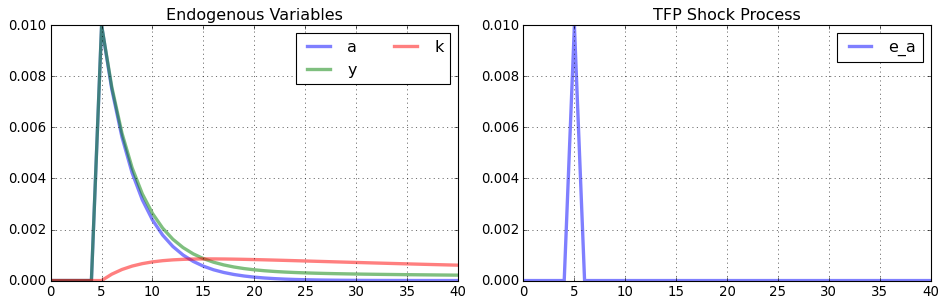

In [27]:
# Plot the computed impulse responses to a TFP shock
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
(solow_model.irs['e_a'][['a','y','k']]).plot(lw=3,alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=2)
ax1.set_title('Endogenous Variables')

ax2 = fig.add_subplot(1,2,2)
solow_model.irs['e_a'][['e_a']].plot(lw=3,alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)
ax2.set_title('TFP Shock Process')

fig.tight_layout()

### Stochastic Simulation

Compute a 201 period stochastic simulation of the model's variables. Set the variance of $\epsilon_t$ to $\sigma^2$ and the variance of the shock to capital to 0 so that the covariance matrix for the shock process is:

\begin{align}
\text{Covariance matrix} & = \left[\begin{array}{cc} \sigma^2 \end{array} \right]
\end{align}

In [28]:
# Compute stochastic simulation and print the simulated values.
solow_model.stoch_sim(seed=126,T=201,variances=[sigma**2])

# Display first 10 rows of `model.simulated`
display(solow_model.simulated.head(10))

,e_a,a,k,y
0,0.005948,0.006464,-0.005922,0.004391
1,-0.004694,0.000154,-0.005664,-0.001828
2,-0.006422,-0.006306,-0.005568,-0.008255
3,-0.007073,-0.011803,-0.005635,-0.013775
4,0.007502,-0.001351,-0.005839,-0.003394
5,-0.006846,-0.007859,-0.005777,-0.009882
6,0.005044,-0.000850,-0.005880,-0.002908
7,0.002906,0.002268,-0.005806,0.000236
8,-0.005177,-0.003476,-0.005655,-0.005455
9,0.000533,-0.002074,-0.005650,-0.004051


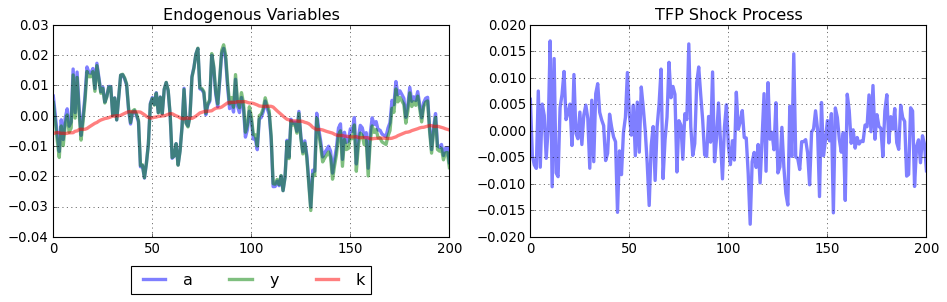

In [29]:
# Plot the computed stochastic simulation
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
(solow_model.simulated[['a','y','k']]).plot(lw=3,alpha=0.5,grid=True,ax = ax1).legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=5)
ax1.set_title('Endogenous Variables')

ax2 = fig.add_subplot(1,2,2)
solow_model.simulated[['e_a']].plot(lw=3,alpha=0.5,grid=True,ax = ax2,legend=False)
ax2.set_title('TFP Shock Process')

fig.tight_layout()

In [30]:
# Compute standard deviations of simulated TFP, output, and capital relative to the steady state of each
(solow_model.simulated[['a','y','k']]).std()

a    0.010284
y    0.010593
k    0.003672
dtype: float64

In [31]:
# Compute correlation coefficients of simulated TFP, output, and capital
solow_model.simulated[['a','y','k']].corr()

,a,y,k
a,1.000000,0.992858,0.181710
y,0.992858,1.000000,0.297726
k,0.181710,0.297726,1.000000
